A code taken from A. Wietek (ed_basic):

In [2]:
# -*- coding: utf-8 -*-
'''
Solution to Exercise 1a

:author: Alexander Wietek
:email: alexander.wietek@uibk.ac.at
:year: 2018
'''
from __future__ import absolute_import, division, print_function

import numpy as np
import scipy as sp
from scipy import sparse
from scipy import linalg
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA

# Step 1: just copied this function from hamiltonian_tfi.py
def get_hamiltonian_sparse(L, J, hx):
    '''
    Creates the Hamiltonian of the Transverse Field Ising model
    '''

    def get_site_value(state, site):
        ''' Function to get local value at a given site '''
        return (state >> site) & 1

    def hilbertspace_dimension(L):
        ''' return dimension of hilbertspace '''
        return 2**L

    # Define chain lattice
    ising_bonds = [(site, (site+1)%L) for site in range(L)]

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(hilbertspace_dimension(L)):

        # Apply Ising bonds
        ising_diagonal = 0
        for bond in ising_bonds:
            if get_site_value(state, bond[0]) == get_site_value(state, bond[1]):
                ising_diagonal += J
            else:
                ising_diagonal -= J
        hamiltonian_rows.append(state)
        hamiltonian_cols.append(state)
        hamiltonian_data.append(ising_diagonal)

        # Apply transverse field
        for site in range(L):

            # Flip spin at site
            new_state = state ^ (1 << site)
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx)

    return hamiltonian_rows, hamiltonian_cols, hamiltonian_data

The below cell returns **all** eigenvalues, for a small (L=4) periodic ising chain when subject to a transverse field. This does so from a sparse matrix. Larger chains can be studied using the sparse matrix and pseudo-diagonalization using the SA method. 

In [19]:
# Step 2: Compute the energies of the lowest 10 eigenvalues for x=0...2
# and plot results
L=4
J=1
# n_lowest_eigenvalues = 50
#n_lowest_eigenvalues = 50 #for sparse matrix, not all eigs are recovered
n_lowest_eigenvalues = 2**4 #all eigs are obtained for small system
n_hx = 20
all_eigenvalues = np.zeros((n_hx,n_lowest_eigenvalues))
hx_values = np.linspace(0,2,n_hx)
for i in range(n_hx):
    hx = hx_values[i]
    rows, cols, data = get_hamiltonian_sparse(L, J, hx)
    #---- using a sparse matrix
    # hamiltonian = sp.sparse.csr_matrix((data, (rows, cols)))
    # eigs = sp.sparse.linalg.eigsh(hamiltonian, k=n_lowest_eigenvalues,
    #                               which='SA', return_eigenvectors=False,
    #                               maxiter=1000, ncv = 10*n_lowest_eigenvalues)
    #---- using a full matrix
    simple_matrix = np.zeros((2**L, 2**L))
    for k in range(len(rows)):
        simple_matrix[rows[k], cols[k]] = data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    all_eigenvalues[i,:] = np.sort(np.real(eigs))
    #print(eigs)
    #print(hx, eigs)


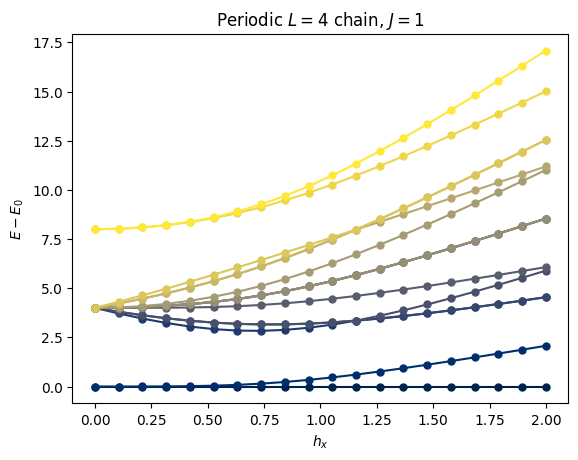

In [20]:
gs_ene = np.array([min(all_eigenvalues[i,:]) for i in range(n_hx)])
colors = plt.cm.cividis(np.linspace(0, 1, n_lowest_eigenvalues))
for j in range(n_lowest_eigenvalues):
    some_index_eigs = all_eigenvalues[:,j]
    plt.plot(hx_values, some_index_eigs - gs_ene, 'o-', markersize = 5, color = colors[j])
plt.xlabel(r"$h_x$")
plt.ylabel(r"$E - E_0$")
plt.title(r'Periodic $L=4$ chain, $J=1$')
#plt.ylim(-0.1, 6)
plt.show()

Defining the parity hamiltonian, for one cell i.e. a single constraint on the 4 spins of a plaquette.

In [21]:
def perm_parity(lst):
    '''\
    Given a permutation of the digits 0..N in order as a list, 
    returns its parity (or sign): +1 for even parity; -1 for odd.
    '''
    parity = 1
    for i in range(0,len(lst)-1):
        if lst[i] != i:
            parity *= -1
            mn = min(range(i,len(lst)), key=lst.__getitem__)
            lst[i],lst[mn] = lst[mn],lst[i]
    return parity    

from itertools import permutations

print('parity for each permutation of N digits')
for p in permutations(range(4)):
    l = list(p)
    print("%2i %r" % (perm_parity(l), p))

parity for each permutation of N digits
 1 (0, 1, 2, 3)
-1 (0, 1, 3, 2)
-1 (0, 2, 1, 3)
 1 (0, 2, 3, 1)
 1 (0, 3, 1, 2)
-1 (0, 3, 2, 1)
-1 (1, 0, 2, 3)
 1 (1, 0, 3, 2)
 1 (1, 2, 0, 3)
-1 (1, 2, 3, 0)
-1 (1, 3, 0, 2)
 1 (1, 3, 2, 0)
 1 (2, 0, 1, 3)
-1 (2, 0, 3, 1)
-1 (2, 1, 0, 3)
 1 (2, 1, 3, 0)
 1 (2, 3, 0, 1)
-1 (2, 3, 1, 0)
-1 (3, 0, 1, 2)
 1 (3, 0, 2, 1)
 1 (3, 1, 0, 2)
-1 (3, 1, 2, 0)
-1 (3, 2, 0, 1)
 1 (3, 2, 1, 0)


Old function, depracted, that did the gadget hamiltonian construction using a sparse matrix. No longer needed.

In [22]:
# Step 1: just copied this function from hamiltonian_tfi.py
def get_gadget_sparse(C, hx):
    L = 4
    '''
    Creates the Hamiltonian of the Transverse Field Ising model
    '''

    def get_site_value(state, site):
        ''' Function to get local value at a given site '''
        return (state >> site) & 1

    def hilbertspace_dimension(L):
        ''' return dimension of hilbertspace '''
        return 2**L

    # Define plaquettes
    plaquettes = [p for p in permutations(range(4))]
    #for spins, communitng S_z operators, so this gives a sequence of products that come with parity +- 1 in the hamiltonian.
    #this helps identify the states

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(hilbertspace_dimension(L)):

        # Apply Ising bonds
        #parity_value = 0
        # for perm in plaquettes:
        #     vals = [get_site_value(state, perm[k]) for k in range(L)]
        #     product = np.prod(vals)
        #     # if perm_parity(list(perm)) == 1:
        #     #     parity_value += C*product
        #     # else:
        #     #     parity_value -= C*product
        #     parity_value += C*product
        vals = np.array([(2*get_site_value(state, plaquettes[0][k]) - 1) for k in range(L)])
        #print(vals)
        parity_value = np.prod(vals)

        hamiltonian_rows.append(state)
        hamiltonian_cols.append(state)
        hamiltonian_data.append(parity_value)

        # Apply transverse field
        for site in range(L):

            # Flip spin at site
            new_state = state ^ (1 << site)
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx)

    return hamiltonian_rows, hamiltonian_cols, hamiltonian_data

Below is the full diagonalization of a single (or multiple if you adapt the code) plaquette with parity constraint when subject to a transverse field.

In [154]:
def get_site_value(state, site):
    ''' Function to get local value at a given site '''
    return (state >> site) & 1


n_sites = 4;
n_lowest_eigenvalues = 2**n_sites #all eigs are obtained for small system
n_hx = 20
hx_max = 2
C=1
all_eigenvalues = np.zeros((n_hx,n_lowest_eigenvalues))
hx_values = np.linspace(0,hx_max,n_hx)

#plaquettes = [(0,1,2,3), (2,4,5,6)]
plaquettes = [(0,1,2,3)]

for i in range(n_hx):
    hx = hx_values[i]

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(2**(n_sites)):
        for l in range(len(plaquettes)):
            vals = np.array([(2*get_site_value(state, plaquettes[l][k]) - 1) for k in range(L)])
            #print(vals)
            parity_value = np.prod(vals)

            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(parity_value)

        # Apply transverse field
        for site in range(L):

            # Flip spin at site
            new_state = state ^ (1 << site)
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx)

    simple_matrix = np.zeros((2**n_sites, 2**n_sites))
    for k in range(len(rows)):
        simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] = hamiltonian_data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    all_eigenvalues[i,:] = np.sort(np.real(eigs))

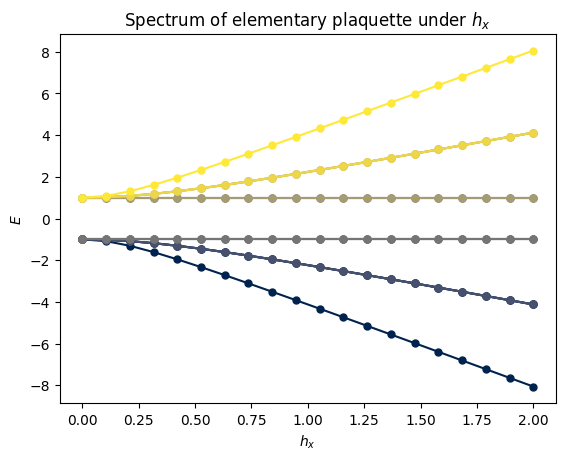

In [155]:
gs_ene = np.array([min(all_eigenvalues[i,:]) for i in range(n_hx)])
colors = plt.cm.cividis(np.linspace(0, 1, n_lowest_eigenvalues))
for j in range(n_lowest_eigenvalues):
    some_index_eigs = all_eigenvalues[:,j]
    plt.plot(hx_values, some_index_eigs - 0*gs_ene, 'o-', markersize = 5, color = colors[j])
plt.xlabel(r"$h_x$")
# plt.ylabel(r"$E - E_0$")
plt.ylabel(r"$E$")
#plt.ylim(-0.1, 6)
plt.title(r'Spectrum of elementary plaquette under $h_x$')
plt.show()

Note that there is always a gap between $C=-1$ and $C=1$ states, but that the degeneracy of these states is broken as soon as $h_x \neq 0$. The degeneracy of each of the three branch is: $n_0 = 1$, $n_1 = 4$ and $n_2 = 3$. If you want the state for a given $h_x$ you can look below.  

In [191]:
def diagonalize_perfect_plaquette(hx, C):
    # hx = 0.0
    n_sites = 4;
    n_lowest_eigenvalues = 2**n_sites #all eigs are obtained for small system
    # C=1
    all_eigenvalues = np.zeros((n_hx,n_lowest_eigenvalues))

    #plaquettes = [(0,1,2,3), (2,4,5,6)]
    plaquettes = [(0,1,2,3)]


    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(2**(n_sites)):
        for l in range(len(plaquettes)):
            vals = np.array([(2*get_site_value(state, plaquettes[l][k]) - 1) for k in range(L)])
            #print(vals)
            parity_value = np.prod(vals)

            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(parity_value)

        # Apply transverse field
        for site in range(L):

            # Flip spin at site
            new_state = state ^ (1 << site)
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx)

    simple_matrix = np.zeros((2**n_sites, 2**n_sites))
    for k in range(len(rows)):
        simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] = hamiltonian_data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    return eigs, eigenvectors


In [209]:
eigs, eigenvectors = diagonalize_perfect_plaquette(0.1, 1)

zero_eigenvalues = np.real(eigs)
#print(zero_eigenvalues[np.argsort(zero_eigenvalues)])
sorted_eigenvalues = zero_eigenvalues[np.argsort(zero_eigenvalues)]
sorted_eigenvectors = eigenvectors[np.argsort(zero_eigenvalues)]

ind_state = 0
state = sorted_eigenvectors[ind_state]
print('E=',sorted_eigenvalues[ind_state])
print(np.nonzero(state))
all_prods = []
all_exp_val = []
for ind in np.nonzero(state)[0]:
    spin_state = [(2*get_site_value(ind, k) - 1) for k in range(4)]
    print(spin_state)
    product = np.prod(np.array(spin_state))
    print('product = ', product)
    all_prods.append(product)
    all_exp_val.append(state[ind])

E= -1.077032961426901
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),)
[-1, -1, -1, -1]
product =  1
[1, -1, -1, -1]
product =  -1
[-1, 1, -1, -1]
product =  -1
[1, 1, -1, -1]
product =  1
[-1, -1, 1, -1]
product =  -1
[1, -1, 1, -1]
product =  1
[-1, 1, 1, -1]
product =  1
[1, 1, 1, -1]
product =  -1
[-1, -1, -1, 1]
product =  -1
[1, -1, -1, 1]
product =  1
[-1, 1, -1, 1]
product =  1
[1, 1, -1, 1]
product =  -1
[-1, -1, 1, 1]
product =  1
[1, -1, 1, 1]
product =  -1
[-1, 1, 1, 1]
product =  -1
[1, 1, 1, 1]
product =  1


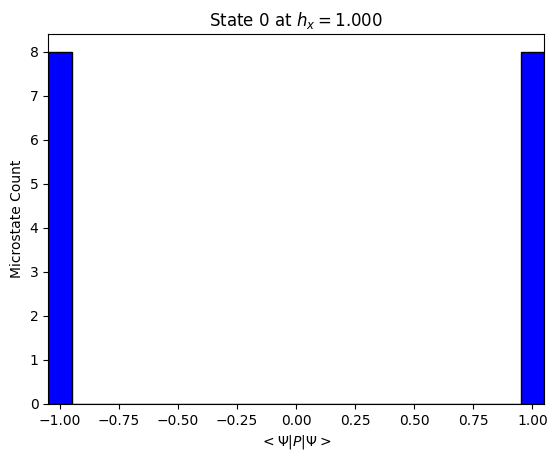

In [205]:
bin_range = np.arange(-1, 2, 0.1) - 0.05
plt.hist(np.array(all_prods), bins=bin_range, edgecolor='black', color = 'blue')

# Customize labels and title
plt.title('State ' + str(ind_state) + r' at $h_x =${:.3f}'.format(hx))
plt.ylabel('Microstate Count')
plt.xlabel(r'$<\Psi|P|\Psi>$')
plt.xlim([-1.05, 1.05])
# Display the histogram
plt.show()

In [210]:
#calculation of '$<\Psi|P|\Psi>$
val = 0.0
for j in range(len(all_prods)):
    val += all_prods[j] * np.abs(all_exp_val[j])**2
print('C_eval = ', val)

C_eval =  -0.2413087313234424


In [211]:
sorted_eigenvalues = np.real(eigs)[np.argsort(np.real(eigs))]
sorted_eigenvectors = eigenvectors[np.argsort(np.real(eigs))]
num_states = len(sorted_eigenvalues)
numbers = [i+1 for i in range(num_states)]
c_values = []
for ind_state in range(num_states):
    state = sorted_eigenvectors[ind_state]
    val = 0.0
    for ind in np.nonzero(state)[0]:
        spin_state = [(2*get_site_value(ind, k) - 1) for k in range(4)]
        product = np.prod(np.array(spin_state))
        val += product * np.abs(state[ind])**2
    c_values.append(val)


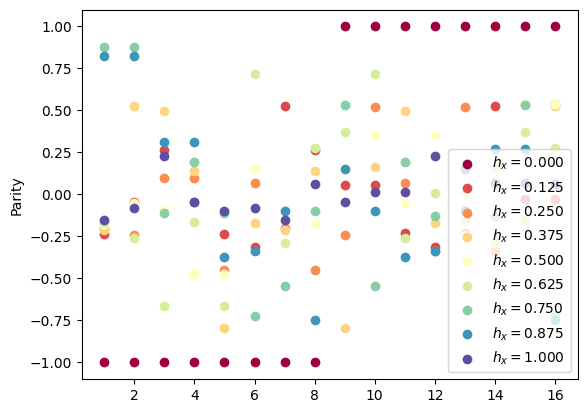

In [216]:
n_hx = 9
hx_max = 1
C=1
hx_values = np.linspace(0,hx_max,n_hx)
count = 0
cmap = plt.colormaps['Spectral']

for hx in hx_values:
    eigs, eigenvectors = diagonalize_perfect_plaquette(hx, 1)

    sorted_eigenvalues = np.real(eigs)[np.argsort(np.real(eigs))]
    #print(sorted_eigenvalues)
    sorted_eigenvectors = eigenvectors[np.argsort(np.real(eigs))]
    num_states = len(sorted_eigenvalues)
    numbers = [i+1 for i in range(num_states)]
    c_values = []
    for ind_state in range(num_states):
        state = sorted_eigenvectors[ind_state]
        val = 0.0
        for ind in np.nonzero(state)[0]:
            spin_state = [(2*get_site_value(ind, k) - 1) for k in range(4)]
            product = np.prod(np.array(spin_state))
            val += product * np.abs(state[ind])**2
        c_values.append(val)

    plt.scatter(numbers, c_values, label = r'$h_x =${:.3f}'.format(hx), color = cmap(count/(len(hx_values) -1)))
    # plt.scatter(numbers, sorted_eigenvalues, label = r'$h_x =${:.3f}'.format(hx), color = cmap(count/(len(hx_values) -1)))
    count +=1
plt.legend()
# plt.ylabel("Energy")
plt.ylabel("Parity")
plt.show()

    
    

Note: reverse annealing trajectories would follow energy lines but allow the system to update its parity, as shown above: the lowest 8 energy states, well separated from the other 8 by a gap that does not close, mix the parity. 

# for the parity gadget:

## C = -1

In [302]:
#parity -1 gadget - it works for the ground state
Jfm = -2
J_dict_odd = {(51, 532): Jfm,
 (55, 532): Jfm,
 (55, 528): Jfm,
 (51, 528): Jfm,
 (43, 532): 1,
 (43, 528): 1,
 (51, 520): 1,
 (51, 524): 1,
 (47, 528): 1,
 (47, 532): 1,
 (55, 520): 1,
 (55, 524): 1,
 (43, 520): 1,
 (43, 524): 1,
 (47, 520): 1,
 (47, 524): 1,
 (43, 47): 1,
 (520, 524): 1}

h_dict_odd = {520: 0, 43: 0, 524: 0, 47: 0, 528: 0, 51: 0, 532: 0, 55: 0}

index_to_site = {}
site_to_index = {}

index = 0
for key in h_dict_odd.keys():
    index_to_site.update({index:key})
    site_to_index.update({key:index})
    index += 1

In [303]:

n_sites = len(index_to_site);
n_lowest_eigenvalues = 2**n_sites #all eigs are obtained for small system
n_hx = 20
max_hx = 1.0
all_eigenvalues = np.zeros((n_hx,n_lowest_eigenvalues))
hx_values = np.linspace(0,max_hx,n_hx)
chain_sites = [51, 55, 528, 532]
logical_sites = [520, 43, 47, 524]

for i in range(n_hx):
    hx = hx_values[i]

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(2**(n_sites)):
        for bond, value in J_dict_odd.items():
            vals = np.array([(2*get_site_value(state, site_to_index[bond[k]]) - 1) for k in range(2)])
            #print(vals)
            #print(vals)
            J_interactions = value*np.prod(vals)
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(J_interactions)

        # Apply h field
        for site in range(n_sites):
            val = 2*get_site_value(state, site) - 1
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(h_dict_odd[index_to_site[site]]*val)

        # Apply transverse field
        for site in range(n_sites):
            # Flip spin at site
            new_state = state ^ (1 << site)
            delay = 1.0
            if index_to_site[site] in chain_sites:
                delay = 1.0 #no delay
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx*delay)

    simple_matrix = np.zeros((2**n_sites, 2**n_sites))
    for k in range(len(hamiltonian_rows)):
        simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] += hamiltonian_data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    all_eigenvalues[i,:] = np.sort(np.real(eigs))

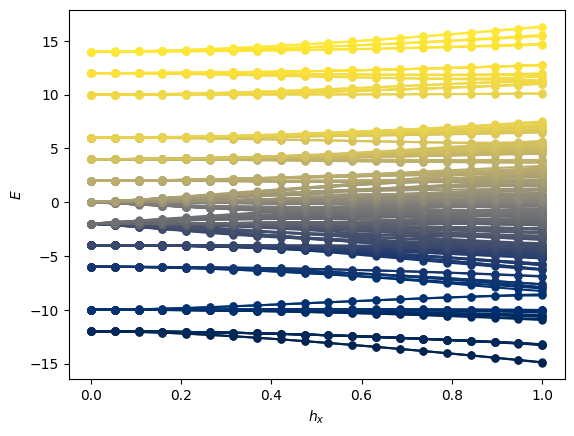

In [304]:
gs_ene = np.array([min(all_eigenvalues[i,:]) for i in range(n_hx)])
colors = plt.cm.cividis(np.linspace(0, 1, n_lowest_eigenvalues))
for j in range(n_lowest_eigenvalues):
    some_index_eigs = all_eigenvalues[:,j]
    plt.plot(hx_values, some_index_eigs - 0*gs_ene, 'o-', markersize = 5, color = colors[j])
plt.xlabel(r"$h_x$")
# plt.ylabel(r"$E - E_0$")
plt.ylabel(r"$E$")
# plt.ylim(-15, -8)
plt.show()

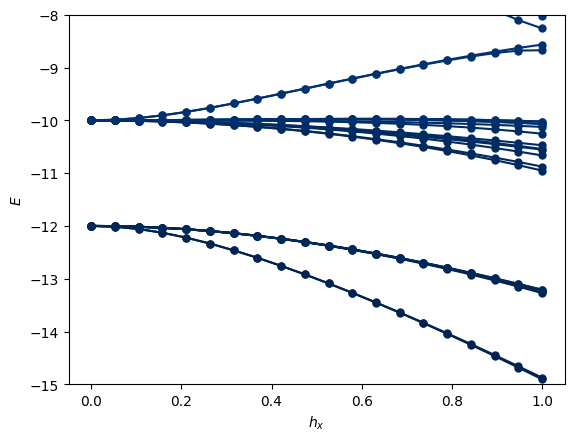

In [305]:
gs_ene = np.array([min(all_eigenvalues[i,:]) for i in range(n_hx)])
colors = plt.cm.cividis(np.linspace(0, 1, n_lowest_eigenvalues))
for j in range(n_lowest_eigenvalues):
    some_index_eigs = all_eigenvalues[:,j]
    plt.plot(hx_values, some_index_eigs - 0*gs_ene, 'o-', markersize = 5, color = colors[j])
plt.xlabel(r"$h_x$")
# plt.ylabel(r"$E - E_0$")
plt.ylabel(r"$E$")
plt.ylim(-15, -8)
plt.show()

The ground state is still 8 fold degenerate, and is separated by a gap from the next excited state. Now, it is unclear whether the 1st excited state has the same structure as in the non-embedded gadget. Below is the exploration for a given $h_x$.

In [306]:
def odd_parity_gadget_diagonalize(hx):
    # hx = 0.1
    n_sites = len(index_to_site);

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(2**(n_sites)):
        for bond, value in J_dict_odd.items():
            vals = np.array([(2*get_site_value(state, site_to_index[bond[k]]) - 1) for k in range(2)])
            #print(vals)
            #print(vals)
            J_interactions = value*np.prod(vals)
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(J_interactions)

        # Apply h field
        for site in range(n_sites):
            val = 2*get_site_value(state, site) - 1
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(h_dict_odd[index_to_site[site]]*val)

        for site in range(n_sites):
            # Flip spin at site
            new_state = state ^ (1 << site)
            delay = 1.0
            if index_to_site[site] in chain_sites:
                delay = 1.0
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx*delay)


    simple_matrix = np.zeros((2**n_sites, 2**n_sites))
    for k in range(len(hamiltonian_rows)):
        simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] += hamiltonian_data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    return eigs, eigenvectors

In [309]:
eigs, eigenvectors = odd_parity_gadget_diagonalize(0)

zero_eigenvalues = np.real(eigs)
#print(zero_eigenvalues[np.argsort(zero_eigenvalues)])
sorted_eigenvalues = zero_eigenvalues[np.argsort(zero_eigenvalues)]
sorted_eigenvectors = eigenvectors[np.argsort(zero_eigenvalues)]

ind_state = 0
state = sorted_eigenvectors[ind_state]
print('E=',sorted_eigenvalues[ind_state])
print(np.nonzero(state))
all_prods = []
all_exp_val = []
#chain_sites = [51, 55, 528, 532]
logical_qubits = [site_to_index[logical_sites[i]] for i in range(4)]
for ind in np.nonzero(state)[0]:
    spin_state = [(2*get_site_value(ind, k) - 1) for k in range(8)]
    print(spin_state)
    product = np.prod(np.array(spin_state)[logical_qubits])
    print('product = ', product)
    all_prods.append(product)
    all_exp_val.append(product*np.abs(state[ind]))



E= -12.0
(array([248]),)
[-1, -1, -1, 1, 1, 1, 1, 1]
product =  -1


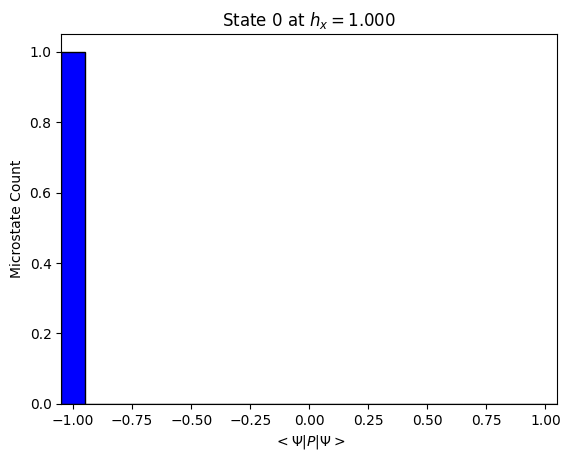

In [310]:
bin_range = np.arange(-1, 2, 0.1) - 0.05
plt.hist(np.array(all_prods), bins=bin_range, edgecolor='black', color = 'blue')

# Customize labels and title
plt.title('State ' + str(ind_state) + r' at $h_x =${:.3f}'.format(hx))
plt.ylabel('Microstate Count')
plt.xlabel(r'$<\Psi|P|\Psi>$')
plt.xlim([-1.05, 1.05])
# Display the histogram
plt.show()

In [311]:
#calculation of '$<\Psi|P|\Psi>$
val = 0.0
for j in range(len(all_prods)):
    val += all_prods[j] * np.abs(all_exp_val[j])**2
print('C_eval = ', val)

C_eval =  -1.0


In [314]:
n_hx = 9
hx_max = 1
hx_values = np.linspace(0,hx_max,n_hx)
# hx_values = [0.0]
logical_qubits = [site_to_index[logical_sites[i]] for i in range(4)]

x_arr = []
y_arr = []
y_e_arr = []

for hx in hx_values:
    eigs, eigenvectors = odd_parity_gadget_diagonalize(hx)

    sorted_eigenvalues = np.real(eigs)[np.argsort(np.real(eigs))]
    #print(sorted_eigenvalues)
    sorted_eigenvectors = eigenvectors[np.argsort(np.real(eigs))]
    num_states = len(sorted_eigenvalues)
    numbers = [i+1 for i in range(num_states)]
    c_values = []
    for ind_state in range(num_states):
        state = sorted_eigenvectors[ind_state]
        val = 0.0
        for ind in np.nonzero(state)[0]:
            spin_state = [(2*get_site_value(ind, k) - 1) for k in range(8)]
            product = np.prod(np.array(spin_state)[logical_qubits])
            val += product * np.abs(state[ind])**2
        c_values.append(val)

    x_arr.append(numbers)
    y_arr.append(c_values)
    y_e_arr.append(sorted_eigenvalues)
    

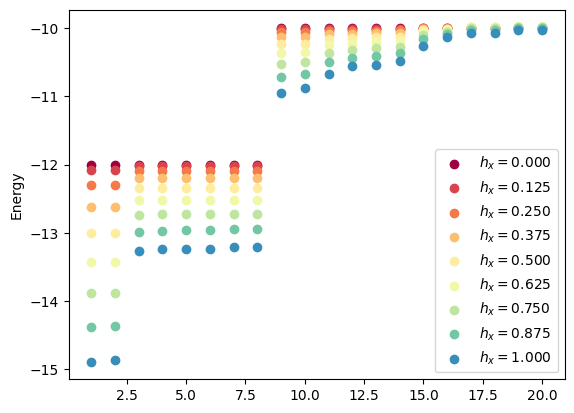

In [321]:
count = 0
count_lim = len(hx_values)
cmap = plt.colormaps['Spectral']
num_lim = 20

for k in range(len(x_arr)):
    # plt.scatter(numbers, c_values, label = r'$h_x =${:.3f}'.format(hx), color = cmap(count/count_lim))
    plt.scatter(x_arr[k][:num_lim], y_e_arr[k][:num_lim], label = r'$h_x =${:.3f}'.format(hx_values[k]), color = cmap(count/count_lim))
    count +=1
plt.legend()
plt.ylabel("Energy")
plt.xlabel("level [integer]")
# plt.ylabel("Parity")
plt.show()


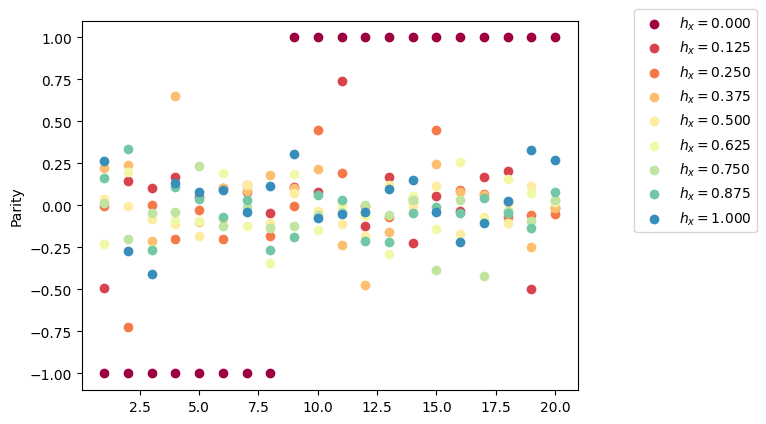

In [320]:
count = 0
count_lim = len(hx_values)
cmap = plt.colormaps['Spectral']

num_lim = 20

for k in range(len(x_arr)):
    # plt.scatter(numbers, c_values, label = r'$h_x =${:.3f}'.format(hx), color = cmap(count/count_lim))
    plt.scatter(x_arr[k][:num_lim], y_arr[k][:num_lim], label = r'$h_x =${:.3f}'.format(hx_values[k]), color = cmap(count/count_lim))
    count +=1
plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.ylabel("Energy")
plt.ylabel("Parity")
plt.xlabel("level [integer]")
plt.show()

The lowest energy state indeed is 8 fold degenerate and is of the required parity.

## C = 1 

In [322]:
#parity 1 gadget
J_dict_even = {(51, 528): -4,
 (55, 524): 2,
 (55, 520): 2,
 (51, 55): 2,
 (528, 532): 2,
 (43, 532): 2,
 (47, 532): 2,
 (51, 520): 1,
 (520, 524): 1,
 (43, 528): 1,
 (51, 524): 1,
 (43, 47): 1,
 (47, 528): 1}
 
h_dict_even = {532: -2, 55: -2, 520: -1, 43: -1, 47: -1, 524: -1, 51: -1, 528: -1}


index_to_site = {}
site_to_index = {}

index = 0
for key in h_dict_even.keys():
    index_to_site.update({index:key})
    site_to_index.update({key:index})
    index += 1

In [323]:
n_sites = len(index_to_site);
n_lowest_eigenvalues = 2**n_sites #all eigs are obtained for small system
n_hx = 20
max_hx = 1.0
all_eigenvalues = np.zeros((n_hx,n_lowest_eigenvalues))
hx_values = np.linspace(0,max_hx,n_hx)
chain_sites = [51, 55, 528, 532]
logical_sites = [520, 43, 47, 524]

for i in range(n_hx):
    hx = hx_values[i]

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(2**(n_sites)):
        for bond, value in J_dict_even.items():
            vals = np.array([(2*get_site_value(state, site_to_index[bond[k]]) - 1) for k in range(2)])
            #print(vals)
            #print(vals)
            J_interactions = value*np.prod(vals)
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(J_interactions)

        # Apply h field
        for site in range(n_sites):
            val = 2*get_site_value(state, site) - 1
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(h_dict_even[index_to_site[site]]*val)

        # Apply transverse field
        for site in range(n_sites):
            # Flip spin at site
            new_state = state ^ (1 << site)
            delay = 1.0
            if index_to_site[site] in chain_sites:
                delay = 1.0 #no delay
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx*delay)

    simple_matrix = np.zeros((2**n_sites, 2**n_sites))
    for k in range(len(hamiltonian_rows)):
        simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] += hamiltonian_data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    all_eigenvalues[i,:] = np.sort(np.real(eigs))

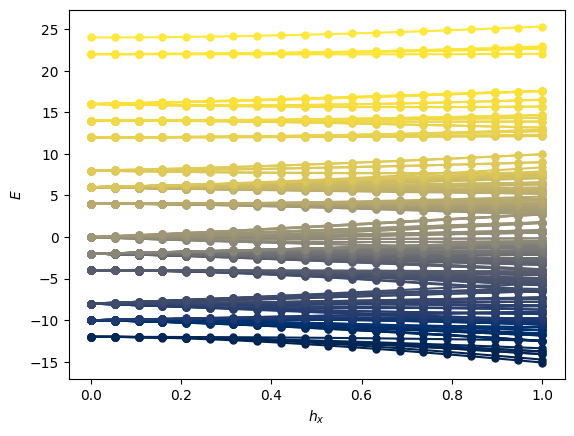

In [324]:
gs_ene = np.array([min(all_eigenvalues[i,:]) for i in range(n_hx)])
colors = plt.cm.cividis(np.linspace(0, 1, n_lowest_eigenvalues))
for j in range(n_lowest_eigenvalues):
    some_index_eigs = all_eigenvalues[:,j]
    plt.plot(hx_values, some_index_eigs - 0*gs_ene, 'o-', markersize = 5, color = colors[j])
plt.xlabel(r"$h_x$")
# plt.ylabel(r"$E - E_0$")
plt.ylabel(r"$E$")
# plt.ylim(-15, -8)
plt.show()

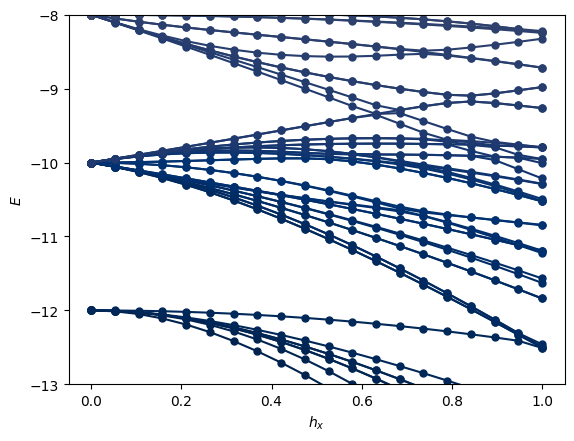

In [325]:
gs_ene = np.array([min(all_eigenvalues[i,:]) for i in range(n_hx)])
colors = plt.cm.cividis(np.linspace(0, 1, n_lowest_eigenvalues))
for j in range(n_lowest_eigenvalues):
    some_index_eigs = all_eigenvalues[:,j]
    plt.plot(hx_values, some_index_eigs - 0*gs_ene, 'o-', markersize = 5, color = colors[j])
plt.xlabel(r"$h_x$")
# plt.ylabel(r"$E - E_0$")
plt.ylabel(r"$E$")
plt.ylim(-13, -8)
plt.show()

In [326]:
def even_parity_gadget_diagonalize(hx):
    # hx = 0.1
    n_sites = len(index_to_site);

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(2**(n_sites)):
        for bond, value in J_dict_even.items():
            vals = np.array([(2*get_site_value(state, site_to_index[bond[k]]) - 1) for k in range(2)])
            #print(vals)
            #print(vals)
            J_interactions = value*np.prod(vals)
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(J_interactions)

        # Apply h field
        for site in range(n_sites):
            val = 2*get_site_value(state, site) - 1
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(h_dict_even[index_to_site[site]]*val)

        for site in range(n_sites):
            # Flip spin at site
            new_state = state ^ (1 << site)
            delay = 1.0
            if index_to_site[site] in chain_sites:
                delay = 1.0
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx*delay)


    simple_matrix = np.zeros((2**n_sites, 2**n_sites))
    for k in range(len(hamiltonian_rows)):
        simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] += hamiltonian_data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    return eigs, eigenvectors

In [330]:
eigs, eigenvectors = even_parity_gadget_diagonalize(0)

zero_eigenvalues = np.real(eigs)
#print(zero_eigenvalues[np.argsort(zero_eigenvalues)])
sorted_eigenvalues = zero_eigenvalues[np.argsort(zero_eigenvalues)]
sorted_eigenvectors = eigenvectors[np.argsort(zero_eigenvalues)]

ind_state = 0
state = sorted_eigenvectors[ind_state]
print('E=',sorted_eigenvalues[ind_state])
#print(np.nonzero(state))
all_prods = []
all_exp_val = []
logical_qubits = [site_to_index[logical_sites[i]] for i in range(4)]
for ind in np.nonzero(state)[0]:
    spin_state = [(2*get_site_value(ind, k) - 1) for k in range(8)]
    print(spin_state)
    product = np.prod(np.array(spin_state)[logical_qubits])
    print('product = ', product)
    all_prods.append(product)
    all_exp_val.append(product*np.abs(state[ind]))



E= -12.0
[1, 1, -1, 1, -1, 1, -1, -1]
product =  1


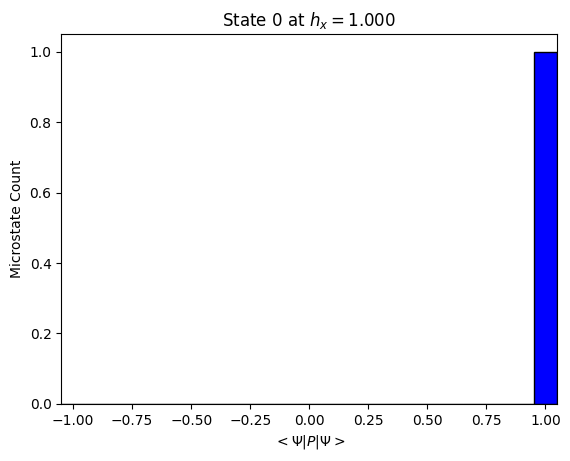

In [331]:
bin_range = np.arange(-1, 2, 0.1) - 0.05
plt.hist(np.array(all_prods), bins=bin_range, edgecolor='black', color = 'blue')

# Customize labels and title
plt.title('State ' + str(ind_state) + r' at $h_x =${:.3f}'.format(hx))
plt.ylabel('Microstate Count')
plt.xlabel(r'$<\Psi|P|\Psi>$')
plt.xlim([-1.05, 1.05])
# Display the histogram
plt.show()

In [332]:
#calculation of '$<\Psi|P|\Psi>$
val = 0.0
for j in range(len(all_prods)):
    val += all_prods[j] * np.abs(all_exp_val[j])**2
print('C_eval = ', val)

C_eval =  1.0


In [334]:
n_hx = 9
hx_max = 1
hx_values = np.linspace(0,hx_max,n_hx)
# hx_values = [0.0]
logical_qubits = [site_to_index[logical_sites[i]] for i in range(4)]

x_arr = []
y_arr = []
y_e_arr = []

for hx in hx_values:
    eigs, eigenvectors = even_parity_gadget_diagonalize(hx)

    sorted_eigenvalues = np.real(eigs)[np.argsort(np.real(eigs))]
    #print(sorted_eigenvalues)
    sorted_eigenvectors = eigenvectors[np.argsort(np.real(eigs))]
    num_states = len(sorted_eigenvalues)
    numbers = [i+1 for i in range(num_states)]
    c_values = []
    for ind_state in range(num_states):
        state = sorted_eigenvectors[ind_state]
        val = 0.0
        for ind in np.nonzero(state)[0]:
            spin_state = [(2*get_site_value(ind, k) - 1) for k in range(8)]
            product = np.prod(np.array(spin_state)[logical_qubits])
            val += product * np.abs(state[ind])**2
        c_values.append(val)

    x_arr.append(numbers)
    y_arr.append(c_values)
    y_e_arr.append(sorted_eigenvalues)
    

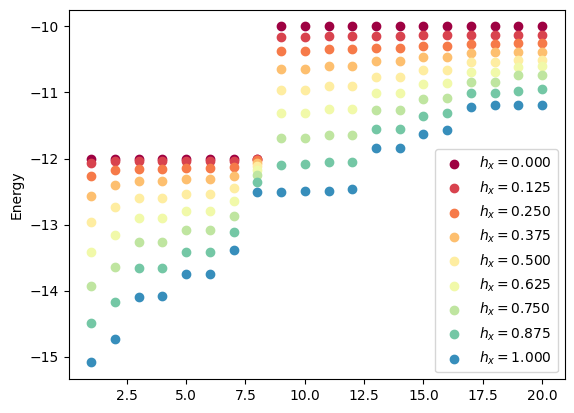

In [335]:
count = 0
count_lim = len(hx_values)
cmap = plt.colormaps['Spectral']
num_lim = 20

for k in range(len(x_arr)):
    # plt.scatter(numbers, c_values, label = r'$h_x =${:.3f}'.format(hx), color = cmap(count/count_lim))
    plt.scatter(x_arr[k][:num_lim], y_e_arr[k][:num_lim], label = r'$h_x =${:.3f}'.format(hx_values[k]), color = cmap(count/count_lim))
    count +=1
plt.legend()
plt.ylabel("Energy")
plt.xlabel("level [integer]")
# plt.ylabel("Parity")
plt.show()


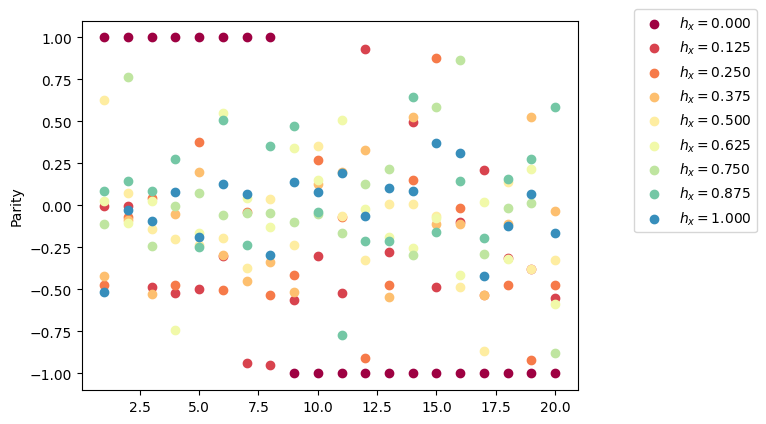

In [336]:
count = 0
count_lim = len(hx_values)
cmap = plt.colormaps['Spectral']

num_lim = 20

for k in range(len(x_arr)):
    # plt.scatter(numbers, c_values, label = r'$h_x =${:.3f}'.format(hx), color = cmap(count/count_lim))
    plt.scatter(x_arr[k][:num_lim], y_arr[k][:num_lim], label = r'$h_x =${:.3f}'.format(hx_values[k]), color = cmap(count/count_lim))
    count +=1
plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.ylabel("Energy")
plt.ylabel("Parity")
plt.xlabel("level [integer]")
plt.show()

!! Careful there is a QPT in this embedding at larger $h_x$